<a href="https://colab.research.google.com/github/ishaan112233/Tensorflow-Basics/blob/master/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
#Importing CIFAR-10 BATCHES
Cifar_dir = "CIFAR/"

In [0]:
def unpickle(file):
    import pickle
    with open(file,'rb') as f:
        cifar_dict = pickle.load(f,encoding='bytes')
    return cifar_dict    

In [0]:
dir = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [0]:
data = [0,1,2,3,4,5,6]

In [0]:
for i,dirr in zip(data,dir):
    data[i] = unpickle(Cifar_dir+dirr)

In [0]:
batch_meta = data[0]
data_batch1 = data[1]
data_batch2 = data[2]
data_batch3 = data[3]
data_batch4 = data[4]
data_batch5 = data[5]
test_batch = data[6]

In [44]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [45]:
data_batch2.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [0]:
x = data_batch1[b'data']
x = x.reshape(10000,3,32,32).transpose(0,2,3,1).astype('uint8')

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

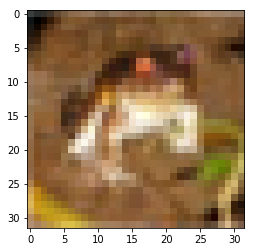

In [48]:
plt.imshow(x[0])

### Helper Functions For Dealing With Data

In [0]:
# For use to one-hot encode the 10- possible labels
def one_hot_encode(vec , vals = 10):
    n = len(vec)
    out = np.zeros((n,vals))
    out[range(n),vec] = 1
    return out

In [0]:
class Cifar():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [51]:
ch = Cifar()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating Model

In [0]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])


In [0]:
y_true = tf.placeholder(tf.float32,shape=[None,10])

## Helper Functions

In [0]:
# init_wt
def init_weight(shape):
    weight = tf.truncated_normal(shape , stddev=0.1)
    return tf.Variable(weight)

In [0]:
# init_bias
def init_bias(shape):
    bias = tf.constant(0.1,shape=shape)
    return tf.Variable(bias)

In [0]:
# Convolution
def conv2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')

In [0]:
#Piiling
def max_pool2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [0]:
def convolution_layer(input_x , shape):
    w = init_weight(shape)
    b = init_bias([shape[3]])
    
    return tf.nn.relu(conv2d(input_x,w)+b)


In [0]:
# Normal (Fully connected layer)
def fully_connected(input_layer , size):
    input_size = int(input_layer.get_shape()[1])
    w = init_weight([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,w) + b

## Creating Layers

In [0]:
convo1 = convolution_layer(x,shape=[4,4,3,32])
convo1_pool = max_pool2(convo1)

In [0]:
convo2 = convolution_layer(convo1_pool,shape=[4,4,32,64])
convo2_pool = max_pool2(convo2)

In [0]:
convo2_flat = tf.reshape(convo2_pool,[-1,8*8*64])

In [0]:
Dense_layer = tf.nn.relu(fully_connected(convo2_flat , 1024))

In [0]:
dropout = tf.placeholder(tf.float32)
dropout_layer = tf.nn.dropout(Dense_layer , keep_prob=dropout)

In [0]:
y_pred = fully_connected(dropout_layer,10)

## Loss Function

In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

## Optimizer

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Initializing Variables

In [0]:
init = tf.global_variables_initializer()

In [87]:
steps = 5000
with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = ch.next_batch(100)
        
        sess.run(train,feed_dict={x:batch_x , y_true:batch_y , dropout:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            prediction = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            accuracy = tf.reduce_mean(tf.cast(prediction , tf.float32))
            
            print(sess.run(accuracy,feed_dict={x:ch.test_images , y_true:ch.test_labels , dropout:1.0}))
            print("\n")

Currently on step 0
Accuracy is:
0.0999


Currently on step 100
Accuracy is:
0.4153


Currently on step 200
Accuracy is:
0.448


Currently on step 300
Accuracy is:
0.4958


Currently on step 400
Accuracy is:
0.5171


Currently on step 500
Accuracy is:
0.5275


Currently on step 600
Accuracy is:
0.54


Currently on step 700
Accuracy is:
0.5755


Currently on step 800
Accuracy is:
0.5785


Currently on step 900
Accuracy is:
0.5689


Currently on step 1000
Accuracy is:
0.5849


Currently on step 1100
Accuracy is:
0.5987


Currently on step 1200
Accuracy is:
0.6153


Currently on step 1300
Accuracy is:
0.6067


Currently on step 1400
Accuracy is:
0.6146


Currently on step 1500
Accuracy is:
0.6258


Currently on step 1600
Accuracy is:
0.6368


Currently on step 1700
Accuracy is:
0.6441


Currently on step 1800
Accuracy is:
0.6446


Currently on step 1900
Accuracy is:
0.6437


Currently on step 2000
Accuracy is:
0.65


Currently on step 2100
Accuracy is:
0.6587


Currently on step 2200
Accu